# Goal
Identify tracks that overperform or underperform relative to their predicted popularity and uncover behavioral or market patterns behind these mismatches.

## 0. Motivation
**Questions**
- Which songs perform better than expected?
- Which songs are overlooked?
- Can we detect hidden gems early?

**Why it matters**
- discovery systems
- playlist curation
- marketing prioritization
- recommendation ranking

## 1. Load Data & Best Model Outputs
**Concept**
We freeze Notebook 05’s best model.

Inputs needed:
- actual popularity
- predicted popularity

**Create**
- predicted_popularity
- residual = actual − predicted

**Interpretation note**
- Residual captures unexplained performance:
- positive → surprise hit
- negative → underperformer

In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../data/processed/base_aligned.parquet")

In [3]:
df.head()

,apple_track_id,apple_artist_id,track_name,artist_name,genre,country,release_date,release_year,release_month,release_ym,...,cover_art_url,bpm,energy,brightness,noisiness,rhythm_strength,artist_followers,artist_popularity,artist_genres,artist_image_url
0,298321904,46087,Music,Erick Sermon,Hip-Hop/Rap,USA,2001-08-27 12:00:00+00:00,2001,8,2001-08,...,https://i.scdn.co/image/ab67616d0000b2737276e4...,99.384014,0.164533,1887.936273,0.080000,2.063508,265997.0,52.0,"['east coast hip hop', 'old school hip hop']",https://i.scdn.co/image/ab6761610000e5ebbefe81...
1,80815173,20044,Music,Madonna,Pop,USA,2000-08-21 07:00:00+00:00,2000,8,2000-08,...,https://i.scdn.co/image/ab67616d0000b2734c8f09...,117.453835,0.181498,2826.828547,0.118955,2.087084,117116492.0,96.0,[],https://i.scdn.co/image/ab6761610000e5eb9e5289...
2,169003415,486597,Don't Stop Believin' (2024 Remaster),Journey,Rock,USA,1981-06-03 07:00:00+00:00,1981,6,1981-06,...,https://i.scdn.co/image/ab67616d0000b27370b5c1...,117.453835,0.093140,2063.243547,0.109971,1.150188,6687304.0,76.0,"['aor', 'classic rock']",https://i.scdn.co/image/ab6761610000e5ebe848df...
3,277635828,156987,I'm Yours,Jason Mraz,Pop,USA,2008-02-12 08:00:00+00:00,2008,2,2008-02,...,https://i.scdn.co/image/ab67616d0000b273125b1a...,151.999081,0.172077,1737.766877,0.061636,1.706438,7337242.0,74.0,"['soft pop', 'acoustic pop']",https://i.scdn.co/image/ab6761610000e5ebc3b370...
4,298429596,46087,Music,Erick Sermon,Hip-Hop/Rap,USA,2001-05-29 07:00:00+00:00,2001,5,2001-05,...,https://i.scdn.co/image/ab67616d0000b2737276e4...,99.384014,0.167033,1868.193043,0.078049,2.053480,265997.0,52.0,"['east coast hip hop', 'old school hip hop']",https://i.scdn.co/image/ab6761610000e5ebbefe81...


In [4]:
release_df = (
    df.groupby(["artist_name","release_date"], observed=True)["track_popularity"]
        .max()
        .reset_index()
        .rename(columns={"track_popularity":"release_max_pop"})
)

In [5]:
release_df = release_df.sort_values(["artist_name","release_date"])

release_df["prev_release_pop"] = (
    release_df.groupby("artist_name")["release_max_pop"]
                .shift(1)
)

release_df["prior_release_mean_pop"] = (
    release_df.groupby("artist_name")["prev_release_pop"]
                .expanding()
                .mean()
                .reset_index(level=0, drop=True)
)

In [6]:
df = df.merge(
    release_df[[
        "artist_name",
        "release_date",
        "prev_release_pop",
        "prior_release_mean_pop"
    ]],
    on=["artist_name","release_date"],
    how="left"
)

In [7]:
df_model = df.dropna(subset=['artist_popularity', 'artist_followers',"prev_release_pop"])
df_model.shape

(6729, 34)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
sns.set_theme(style="white")

class MusicPalette:
    spotify = "#1DB954"   # platform / artist power
    apple = "#FF375F"     # target / popularity / outcome
    navy = "#1D3557"      # behavioral / audio features
    teal = "#2A9D8F"      # secondary analytic / comparisons
    violet = "#6A4C93"    # temporal / momentum / artist history
    amber = "#F4A261"     # feature emphasis
    gold = "#E9C46A"      # highlight (hits / top segments)
    cyan = "#4CC9F0"      # auxiliary / lighter contrasts
    gray = "#6C757D"      # neutral / background / dense points

music_palette = MusicPalette()

sns.set_palette([
    music_palette.spotify,
    music_palette.apple,
    music_palette.navy,
    music_palette.teal,
    music_palette.violet,
    music_palette.amber,
    music_palette.gold,
    music_palette.cyan,
    music_palette.gray,
])

plt.rcParams.update({
    "axes.titleweight": "normal",
    "axes.titlesize": 12,
    "axes.labelsize": 10.5,
    "axes.labelcolor": "#333333",
    "axes.edgecolor": "#444444",
    "axes.linewidth": 0.7,
    "font.size": 10.5,
})

sns.set_style("whitegrid", {
    "grid.linestyle": "-",
    "grid.linewidth": 0.4,
    "grid.color": "#E6E6E6"
})

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [11]:
X = df_model[['artist_popularity', 'artist_followers','prev_release_pop', 'prior_release_mean_pop', 'track_time_min']]
y = df_model['track_popularity']

In [12]:
lr = LinearRegression()
lr.fit(X, y)
df_model = df_model.copy()
df_model["predicted_popularity"] = lr.predict(X)

### Visual: Actual vs Predicted Popularity

This scatterplot checks whether predictions are roughly aligned with reality.
We expect a positive trend, but with substantial noise (popularity has many unobserved factors).

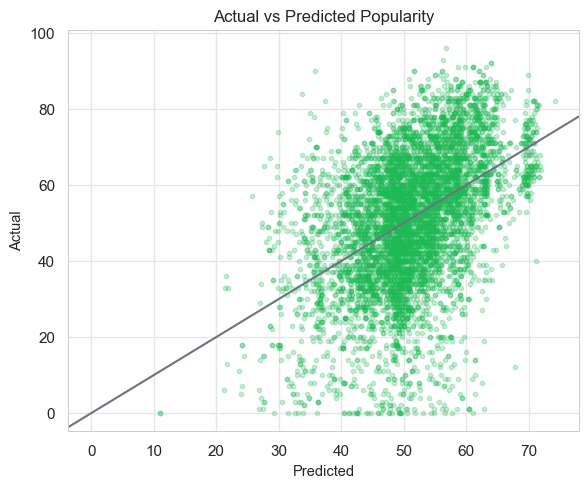

In [40]:
plt.figure(figsize=(6,5))

plt.scatter(
    df_model["predicted_popularity"],
    df_model["track_popularity"],
    s=10,
    alpha=0.25,
    color=music_palette.spotify
)

plt.axline((0,0), slope=1, color=music_palette.gray)

plt.title("Actual vs Predicted Popularity")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.savefig("../images/fig13_actual_vs_predicted.png", dpi=300)
plt.show()

## 2. Residual Analysis (Behavior Gap Signal)

In [14]:
df_model = df_model.copy()

df_model["residual"] = (
    df_model["track_popularity"] 
    - df_model["predicted_popularity"]
)

In [15]:
df_model["residual"].describe()

count    6.729000e+03
mean    -5.000937e-15
std      1.585771e+01
min     -6.183205e+01
25%     -9.588012e+00
50%      7.031586e-01
75%      1.131939e+01
max      5.414698e+01
Name: residual, dtype: float64

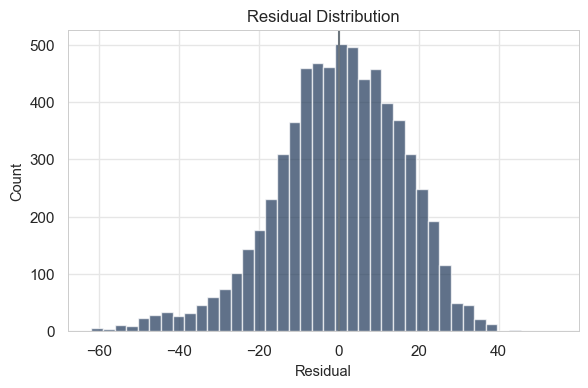

In [41]:
plt.figure(figsize=(6,4))

plt.hist(
    df_model["residual"],
    bins=40,
    color=music_palette.navy,
    alpha=0.7
)

plt.axvline(0, color=music_palette.gray)

plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("../images/fig14_residual_distribution.png", dpi=300)
plt.show()

Even after controlling for artist reputation and momentum, substantial unexplained variance remains, suggesting that listener behavior and market dynamics play a large role in determining success.

### Visual: Residual vs Prior Momentum

If momentum fully explained popularity, residuals would cluster near 0.

This plot checks whether large surprises still occur even for
high-momentum artists.

Wide spread indicates that popularity is not purely driven by reputation/history.

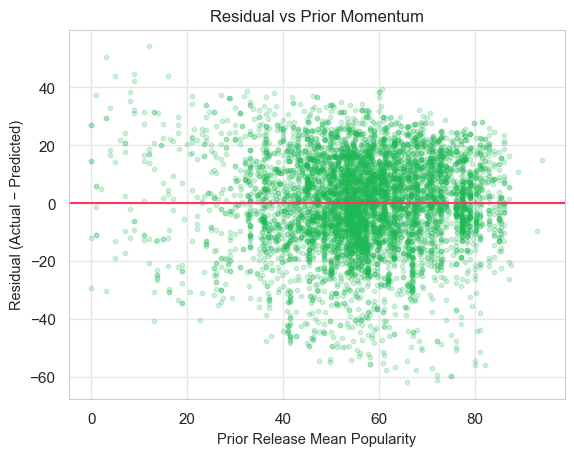

In [42]:
plt.figure()
plt.scatter(
    df_model["prior_release_mean_pop"],
    df_model["residual"],
    alpha=0.2, s=10
)

plt.axhline(0, color=music_palette.apple)
plt.title("Residual vs Prior Momentum")
plt.xlabel("Prior Release Mean Popularity")
plt.ylabel("Residual (Actual − Predicted)")
plt.savefig("../images/fig15_residual_vs_prior_momentum.png", dpi=300)
plt.show()

## 3. Segment Tracks by Performance

Residuals measure how much each song deviates from expectations.

To make interpretation easier, we segment tracks into categories:

- Surprise Hits: performed much better than expected
- Expected: performed close to predictions
- Underrated: performed much worse than expected

This segmentation helps us:
- identify hidden gems
- detect missed opportunities
- understand behavioral or market anomalies


In [18]:
def segment_track(r):
    if r >= 20:
        return "surprise_hit"
    elif r <= -20:
        return "underrated"
    else:
        return "expected"

df_model["segment"] = df_model["residual"].apply(segment_track)

### Segment Sizes

We check how many tracks fall into each category to understand
how common large market mismatches are.

In [19]:
df_model["segment"].value_counts(normalize=True)

segment
expected        0.808292
underrated      0.097488
surprise_hit    0.094219
Name: proportion, dtype: float64

### Visual: Segment Proportions

We visualize the share of tracks that are expected, underrated, and surprise hits.

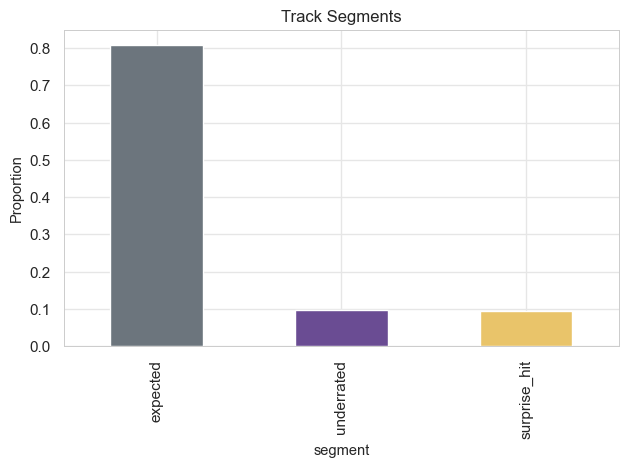

In [43]:
(
    df_model["segment"]
    .value_counts(normalize=True)
    .reindex(["expected","underrated","surprise_hit"])
    .plot(
        kind="bar",
        color=[
            music_palette.gray,
            music_palette.violet,
            music_palette.gold
        ]
    )
)

plt.title("Track Segments")
plt.ylabel("Proportion")

plt.tight_layout()
plt.savefig("../images/fig16_segment_proportions.png", dpi=300)
plt.show()

## 4. Underrated Track Analysis

Underrated tracks are songs that our model expected to perform well
(based on artist reputation and prior momentum) but actually performed poorly.

These represent potential:
- missed opportunities
- poor exposure
- niche audiences
- marketing failures

Understanding their shared traits may reveal:
- structural blind spots in discovery systems
- segments that are underserved


In [21]:
underrated_df = df_model[df_model["segment"] == "underrated"]

In [22]:
underrated_df.shape

(656, 37)

### Compare Underrated vs Overall

We compare summary statistics to understand:
Do underrated songs systematically differ in artist strength, genre, or audio traits?

In [23]:
features = ['artist_popularity', 'artist_followers','prev_release_pop',
            'prior_release_mean_pop', 'track_time_min', 'track_popularity']

means = underrated_df[features].mean().round(3)

print("=== Underrated ===")
for name, value in means.items():
    print(f"{name}: {value:,.3f}")

=== Underrated ===
artist_popularity: 74.697
artist_followers: 13,781,860.317
prev_release_pop: 53.436
prior_release_mean_pop: 53.906
track_time_min: 3.865
track_popularity: 18.873


In [24]:
overall_means = df_model[features].mean().round(3)

print("=== Overall ===")
for name, value in overall_means.items():
    print(f"{name}: {value:.3f}")

=== Overall ===
artist_popularity: 75.202
artist_followers: 16109093.814
prev_release_pop: 56.779
prior_release_mean_pop: 56.831
track_time_min: 3.886
track_popularity: 51.139


### Investigating Why Strong Artists Still Underperform

Since underrated tracks have similar artist strength to the overall dataset,
their poor performance is unlikely due to reputation.

This suggests contextual or exposure-related factors such as:
- non-title tracks
- less playlist placement
- niche genres
- longer/less radio-friendly songs
- release timing effects

Next, we examine genre and audio characteristics to identify patterns.

In [25]:
print("=== Underrated ===")
underrated_df["genre"].value_counts(normalize=True).head(10)

=== Underrated ===


genre
Pop                 0.225610
Country             0.175305
Alternative         0.121951
Rock                0.114329
Hip-Hop/Rap         0.086890
Hard Rock           0.051829
R&B/Soul            0.044207
Classical           0.044207
Metal               0.032012
Children's Music    0.025915
Name: proportion, dtype: float64

In [26]:
print("=== Overall ===")
df_model["genre"].value_counts(normalize=True).head(10)

=== Overall ===


genre
Pop                  0.242830
Country              0.161540
Rock                 0.136276
Alternative          0.126022
Hip-Hop/Rap          0.101204
Hard Rock            0.065983
R&B/Soul             0.038193
Soundtrack           0.024669
Singer/Songwriter    0.014712
Christian            0.014564
Name: proportion, dtype: float64

In [27]:
u = underrated_df["genre"].value_counts(normalize=True)
o = df_model["genre"].value_counts(normalize=True)

compare = (
    pd.concat([u, o], axis=1, keys=["underrated", "overall"])
    .fillna(0)
)

compare["diff"] = compare["underrated"] - compare["overall"]

compare.sort_values("diff", ascending=False).head(10)

,underrated,overall,diff
genre,,,
Classical,0.044207,0.006390,0.037817
Children's Music,0.025915,0.005201,0.020713
Metal,0.032012,0.014118,0.017894
Country,0.175305,0.161540,0.013765
Fitness & Workout,0.009146,0.001337,0.007809
R&B/Soul,0.044207,0.038193,0.006014
Holiday,0.012195,0.006242,0.005953
Psychedelic,0.003049,0.000297,0.002752
Pop Latino,0.003049,0.001783,0.001265


| genre      | diff  |
| ---------- | ----- |
| Classical  | +3.5% |
| Children’s | +2.2% |
| Country    | +1.9% |
| Metal      | +2.0% |
| R&B/Soul   | +0.8% |

### Visual: Residual Distribution by Genre (Top Genres)

This highlights whether some genres systematically over/underperform relative to expectations.

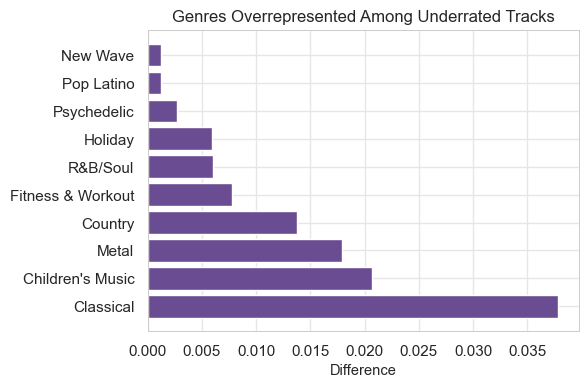

In [44]:
top = compare.sort_values("diff", ascending=False).head(10)

plt.figure(figsize=(6,4))
plt.barh(top.index, top["diff"], color=music_palette.violet)

plt.title("Genres Overrepresented Among Underrated Tracks")
plt.xlabel("Difference")

plt.tight_layout()
plt.savefig("../images/fig17_underrated_genre_bias.png", dpi=300)
plt.show()

### Visual: Genres Overrepresented Among Underrated Tracks

We plot the difference in genre share (underrated − overall).
Positive values indicate genres disproportionately likely to underperform.

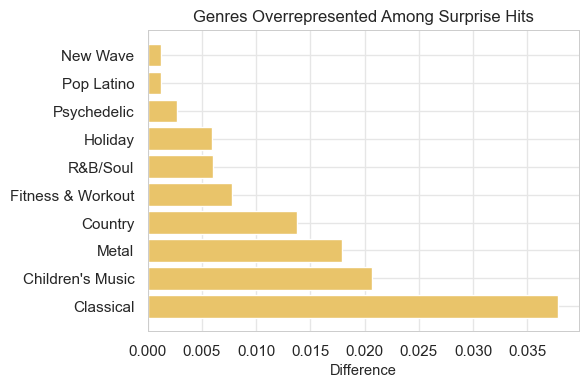

In [45]:
top = compare.sort_values("diff", ascending=False).head(10)

plt.figure(figsize=(6,4))
plt.barh(top.index, top["diff"], color=music_palette.gold)

plt.title("Genres Overrepresented Among Surprise Hits")
plt.xlabel("Difference")

plt.tight_layout()
plt.savefig("../images/fig18_surprise_genre_bias.png", dpi=300)
plt.show()

In [33]:
surprise_df = df_model[df_model["segment"] == "surprise_hit"]

## 5. Surprise Hit Analysis

Surprise hits are songs that performed much better than expected.

These may reveal:
- emerging trends
- viral dynamics
- audio traits that resonate strongly with listeners
- discovery system amplification effects

In [34]:
means_surprise = surprise_df[features].mean().round(3)
overall_means = df_model[features].mean().round(3)

print("=== Surprise Hits ===")
for name, value in means_surprise.items():
    print(f"{name}: {value:.3f}")

print("\n=== Overall ===")
for name, value in overall_means.items():
    print(f"{name}: {value:.3f}")

=== Surprise Hits ===
artist_popularity: 75.276
artist_followers: 15214238.437
prev_release_pop: 52.782
prior_release_mean_pop: 51.931
track_time_min: 3.885
track_popularity: 74.732

=== Overall ===
artist_popularity: 75.202
artist_followers: 16109093.814
prev_release_pop: 56.779
prior_release_mean_pop: 56.831
track_time_min: 3.886
track_popularity: 51.139


In [35]:
compare_means = pd.concat(
    [means_surprise, overall_means],
    axis=1,
    keys=["surprise", "overall"]
)

compare_means["diff"] = compare_means["surprise"] - compare_means["overall"]

compare_means

,surprise,overall,diff
artist_popularity,7.527600e+01,7.520200e+01,0.074
artist_followers,1.521424e+07,1.610909e+07,-894855.377
prev_release_pop,5.278200e+01,5.677900e+01,-3.997
prior_release_mean_pop,5.193100e+01,5.683100e+01,-4.900
track_time_min,3.885000e+00,3.886000e+00,-0.001
track_popularity,7.473200e+01,5.113900e+01,23.593


In [36]:
u = surprise_df["genre"].value_counts(normalize=True)
o = df_model["genre"].value_counts(normalize=True)

compare_genre = (
    pd.concat([u, o], axis=1, keys=["surprise", "overall"])
    .fillna(0)
)

compare_genre["diff"] = compare_genre["surprise"] - compare_genre["overall"]

compare_genre.sort_values("diff", ascending=False).head(10)

,surprise,overall,diff
genre,,,
Pop,0.301262,0.242830,0.058432
Rock,0.148265,0.136276,0.011989
Hard Rock,0.077287,0.065983,0.011304
Christian,0.022082,0.014564,0.007518
R&B/Soul,0.044164,0.038193,0.005971
Música tropical,0.007886,0.002972,0.004914
Christmas: Classic,0.004732,0.000743,0.003989
Latin,0.004732,0.001189,0.003543
Comedy,0.003155,0.000892,0.002263


### Visual: Genres Overrepresented Among Surprise Hits

Positive values indicate genres disproportionately likely to overperform expectations.

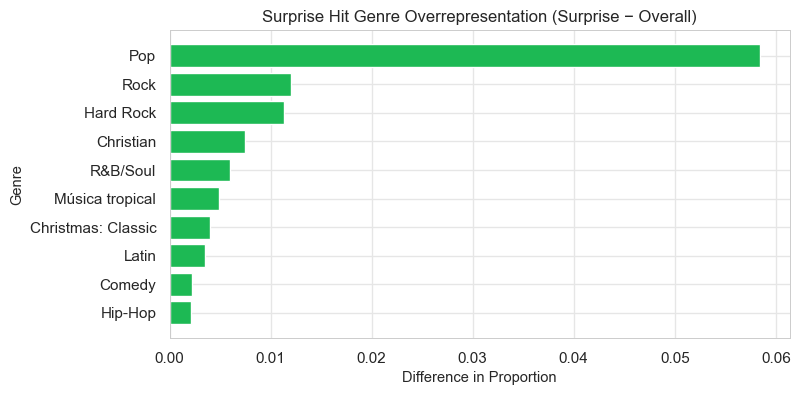

In [46]:
top_diff_sur = compare_genre.sort_values("diff", ascending=False).head(10)

plt.figure(figsize=(8, 4))
plt.barh(top_diff_sur.index, top_diff_sur["diff"])
plt.title("Surprise Hit Genre Overrepresentation (Surprise − Overall)")
plt.xlabel("Difference in Proportion")
plt.ylabel("Genre")
plt.gca().invert_yaxis()
plt.savefig("../images/fig19_surprise_genre_overrepresentation.png", dpi=300)
plt.show()

# 7. Final Conclusions

## Key Findings

### 1. Momentum explains some — but not all — popularity
Artist reputation and prior release performance provide useful signals,
but large residuals remain even after modeling.

Popularity cannot be predicted by artist strength alone.

---

### 2. ~20% of tracks behave unexpectedly
Nearly one in five songs either:
- overperform (surprise hits), or
- underperform (underrated)

This indicates substantial behavioral or exposure-driven effects beyond historical momentum.

---

### 3. Underrated tracks are not weak artists — they are underexposed segments
Underrated songs show:
- similar artist popularity
- similar follower counts
- similar momentum
- similar duration

But are disproportionately:
- niche genres (Classical, Children’s, Metal, Country)

This suggests **discovery or recommendation blind spots**, not artist quality issues.

---

### 4. Surprise hits concentrate in mainstream genres
Surprise hits tend to:
- come from average or slightly weaker momentum
- but over-index heavily in mainstream genres (Pop, Rock, R&B)

This implies **algorithmic amplification or broader exposure advantages**.

---

## Interpretation

Together, these patterns suggest that music success is shaped not only by artist reputation,
but also by platform dynamics and discovery mechanisms.

Discovery systems appear to:
- amplify already mainstream genres
- underexpose niche genres

This creates structural inequalities in visibility.

---

## Product / UX Implications

These findings can inform:

- playlist curation strategies
- marketing prioritization
- early identification of hidden gems
- fairness-aware recommendation design
- improving exposure diversity in discovery systems

---

## Takeaway

Popularity is not purely merit-based.

Even strong artists can be overlooked,
while mainstream genres receive disproportionate amplification.

Understanding these behavioral gaps helps design
more equitable and effective recommendation systems.